# Markov Chain Monte Carlo

![](fig/markov-chain-monte-carlo.png)

The term "Markov Chain Monte Carlo" refers to two concepts:

- The *Monte Carlo* technique uses repeated random samples to estimate a numerical result.
- A *Markov Chain* is a process where the next state depends only on the current state (it's "memoryless").

What are we aiming to do? Draw samples from the posterior distribution.

We could attempt to do this with normal Monte Carlo techniques, but that would require us to generate *independent* samples from the posterior distribution. And in order to do that we would need to *invert* the distribution. And that would be challenging because the evidence is tricky to evaluate!

Fortunately *Markov Chain* Monte Carlo allows us to sample from the posterior distribution without inverting it!

Markov Chain Monte Carlo is a technique which uses random samples to select the next state of the system and where the distribution of those samples depends only on the current state of the system.

A Markov Chain is a remarkably powerful model and is a good approximation for many phenomena. The weather, for example, can be modelled as a Markov Chain: today's weather is a good predictor of tomorrow's weather (and what happened prior to today is probably not important).

Individual Markov Chains are initiated from diffuse locations in parameter space.

There are a variety of algorithms for Markov Chain Monte Carlo (MCMC). We'll be considering (and implementing) the Metropolis-Hastings Algorithm.

<!--
Reference material:

https://arxiv.org/abs/1701.02434
https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/
https://people.duke.edu/~ccc14/sta-663/MCMC.html
-->

In [1]:
import math

import numpy as np
np.random.seed(23)

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

from scipy import stats, optimize

The goal is to gain an intuitive understanding of the [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) for Markov Chain Monte Carlo.

## Problem Setup

Let's create a simple data set for illustration. 

In [2]:
observed = np.array([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

The data represents a process where the possible outcomes are either 0 ("false" or "failure") or 1 ("true" or "success"). Simply calculating the mean give the (frequentist) estimate of the success probability.

We'll model the data as a Bernoulli process with success probability $\theta$. Our goal will be to find the value of $\theta$.

### Quick Frequentist Assessment

In [3]:
mu = observed.mean()
# Standard deviation of the mean.
sigma = math.sqrt(mu * (1 - mu) / observed.size)

In [4]:
print('mean = %.3f | standard deviation = %.3f.' % (mu, sigma))

mean = 0.750 | standard deviation = 0.097.


We can get the 95% confidence interval for $\theta$.

In [5]:
(mu - 2 * sigma, mu + 2 * sigma)

(0.5563508326896291, 0.9436491673103709)

Quoting the mean without giving the standard deviation or the confidence interval is very misleading.

## Maximising the Likelihood

One approach to finding $\theta$ is to maximise the likelihood. The likelihood is the joint probability of the data given the model and a specific value of $\theta$.

In [6]:
def likelihood(theta):
    return stats.bernoulli(theta).pmf(observed).prod()

def log_likelihood(theta):
    return np.log(stats.bernoulli(theta).pmf(observed)).sum()

/home/jupyter/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


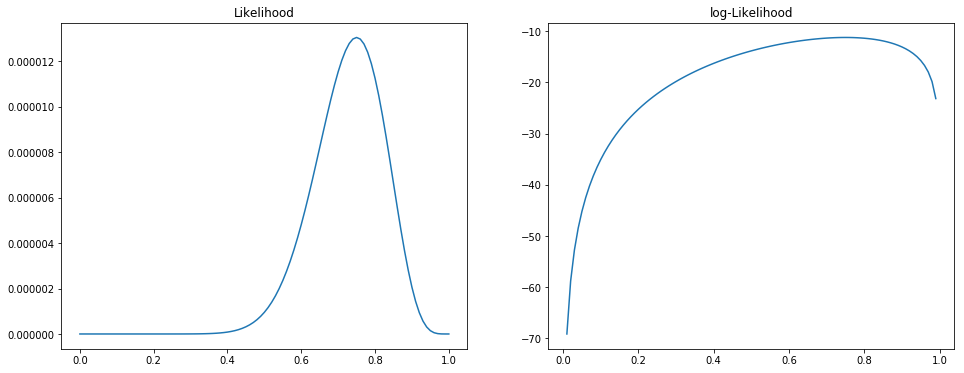

In [7]:
theta = np.linspace(0, 1, 101)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(theta, [likelihood(x) for x in theta])
ax2.plot(theta, [log_likelihood(x) for x in theta])
ax1.set_title('Likelihood')
ax2.set_title('log-Likelihood')
plt.show()

We want to maximise the likelihood, however, most optimisers aim to miminise the objective function, so instead we will minimise the negative likelihood.

In [8]:
optimize.minimize_scalar(lambda theta: -likelihood(theta), bounds=(0, 1), method='bounded')

     fun: -1.305025489273184e-05
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.750000030281249

We get the same result (within numerical precision) from maximising the log-likelihood.

In [9]:
optimize.minimize_scalar(lambda theta: -log_likelihood(theta), bounds=(0, 1), method='bounded')

     fun: 11.246702892376582
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.7499999119034269

## MCMC Algorithm

1. Sample an initial value for $\theta_0$. Set $i = 0$.
2. Sample a *proposal* value, $\theta^\prime$, in the vicinity of $\theta_i$ using $\theta^\prime = \theta_i + \Delta\theta$ where $\Delta\theta$ is drawn from a suitable distribution.
3. Calculate the acceptance ratio, which is the ratio of the posterior evaluated at $\theta^\prime$ and $\theta_i$:
    $$
    r = \frac{p(X|\theta^\prime) p(\theta^\prime)}{p(X|\theta_i) p(\theta_i)}.
    $$
4. Accept or reject the proposal depending on
    - if $r \geq 1$ then set $\theta_{i+1} = \theta^\prime$ or
    - if $r < 1$ then set $\theta_{i+1} = \theta^\prime$ with probability $r$ otherwise set $\theta_{i+1} = \theta_i$.
5. Assign $i \leftarrow i + 1$ and return to step 2.

Step 2 is the "Markov Chain" component: the new value, $\theta^\prime$, depends only on the present value, $\theta$. There are a variety of proposal distributions, but a simple approach is to sample $\Delta\theta$ from a narrow Normal distribution.

Step 3 is where we get around calculating the evidence because it divides out in the ratio of posterior probabilities.

### Choosing a Prior

Choose from one of the two following definitions of `prior`.

In [10]:
# A completely non-informative prior: theta is equally likely to be any value between 0 and 1.
# prior = stats.uniform()

In [11]:
# A slightly more informative prior.
prior = stats.beta(20, 20)

Let's see what that looks like.

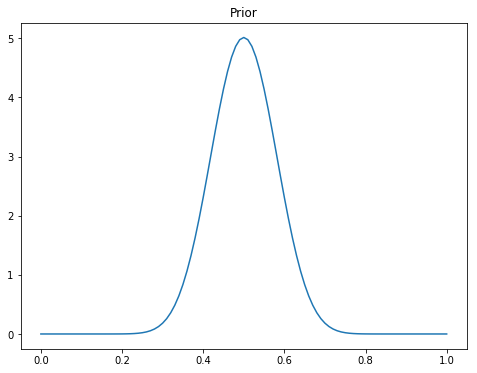

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(theta, [prior.pdf(x) for x in theta])
ax.set_title('Prior')
plt.show()

### Sampling the Posterior

A function that implements MCMC.

In [13]:
# data    = observations
# prior   = prior density
# samples = posterior samples
def mcmc_step(data, prior, samples, verbose=False, step_size=0.1):
    current = samples[-1]
    # Sampled potential new value for theta(in the vicinity of existing value!).
    proposal = stats.norm(current, step_size).rvs()
    
    # Likelihoods.
    likelihood_current = stats.bernoulli(current).pmf(data).prod()
    likelihood_proposal = stats.bernoulli(proposal).pmf(data).prod()
    
    # Prior probabilities of most recent and potential new values for theta.
    prior_current = prior.pdf(current)
    prior_proposal = prior.pdf(proposal)
    
    # Probability of accepting proposal.
    r = (likelihood_proposal * prior_proposal) / (likelihood_current * prior_current)
    r = min(r, 1)
    
    random = np.random.rand()    
    accept = random < r
    
    if accept:
        samples.append(proposal)
    else:
        samples.append(current)
    
    if verbose:
        print('current:  %.6f | L = %.3e prior = %.6f' % (current, likelihood_current, prior_current))
        print('proposal: %.6f | L = %.3e prior = %.6f' % (proposal, likelihood_proposal, prior_proposal))
        print('\nthreshold = %.6f + random = %.6f -> %s' % (r, random, 'accept' if accept else 'reject'))
        plot_sample(data, prior, current, proposal, accept, samples)
    
    return samples

The proposal, $\theta^\prime$, is sampled in the vicinity of the previous sample, $\theta$. The width of the proposal distributionn is important:

- if it's too big then the rejection rate would be too high but
- if it's too small then mixing would be indequate (and sampling would be more like a random walk).

Either extreme would still get you to the correct result... but more slowly! Choosing a decent value for the proposal width will help the algorithm perform *efficiently*.

We're simply calculating the likelihood of the data. This works fine for a limited number of data points. However, if the data becomes large, then multiplying together the individual probabilities can result in floating point underflow. In this case it would make more sense to calculate the log-likelihood.

In [14]:
def plot_sample(data, prior, current, proposal, accept, samples):
    x = np.linspace(0, 1, 1000)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    color = 'g' if accept else 'r'
    k = data.sum()
    n = data.size
    
    prior_pdf = prior.pdf(x)
    likelihood = [stats.binom.pmf(k, n, theta) for theta in x]
    
    ax1.plot(x, prior_pdf)
    ax1.plot([current] * 2, [0, prior.pdf(current)], color='k', label='current')
    ax1.plot([proposal] * 2, [0, prior.pdf(proposal)], color='k', linestyle='--', label='proposal')
    ax1.set_xticks(np.linspace(0, 1, 11), minor=True)
    ax1.grid(axis='x', linestyle='--', linewidth=0.5, which='minor')
    ax1.set(title='Prior')
    ax1.legend()
    
    ax2.plot(x, likelihood)
    ax2.plot([current] * 2, [0, stats.binom.pmf(k, n, current)], color='k')
    ax2.plot([proposal] * 2, [0, stats.binom.pmf(k, n, proposal)], color='k', linestyle='--')
    ax2.set_xticks(np.linspace(0, 1, 11), minor=True)
    ax2.grid(axis='x', linestyle='--', linewidth=0.5, which='minor')
    ax2.set(title='Likelihood')
    
    ax3.plot(x, prior_pdf * likelihood)
    ax3.plot([current] * 2, [0, prior.pdf(current) * stats.binom.pmf(k, n, current)], color='k')
    ax3.plot([proposal] * 2, [0, prior.pdf(proposal) * stats.binom.pmf(k, n, proposal)], color='k', linestyle='--')
    ax3.set_xticks(np.linspace(0, 1, 11), minor=True)
    ax3.grid(axis='x', linestyle='--', linewidth=0.5, which='minor')
    ax3.set(title='Posterior')
    
    ax3.annotate('•', (0, 0), (0.8, 0.8), xycoords='data', textcoords='axes fraction', color=color, size=60)
    
    ax4.plot(samples, marker='o')
    ax4.set(title='Sample Trace', xlabel='Iteration', ylabel='theta')
    
    plt.tight_layout()

Initiate Markov Chain by taking a sample from the prior.

In [15]:
posterior = [prior.rvs()]
posterior

[0.53517628400623]

First iteration of the Markov Chain. New samples will be accumulated in `posterior`. In the plots the current value is the solid vertical line, while the proposal is the dashed vertical line.

current:  0.535176 | L = 1.836e-06 prior = 4.563662
proposal: 0.605343 | L = 5.142e-06 prior = 2.116400

threshold = 1.000000 + random = 0.167139 -> accept


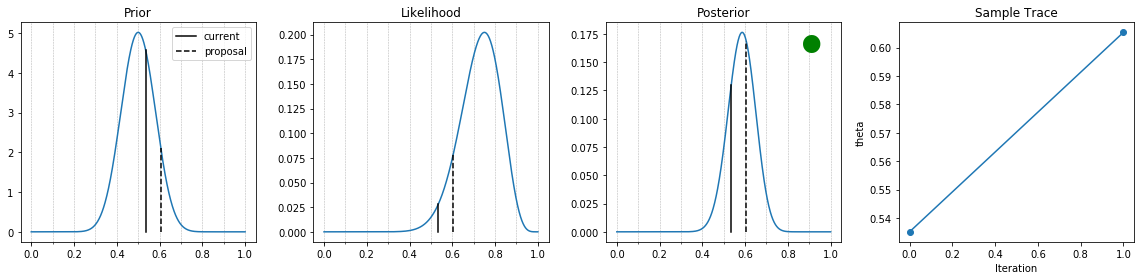

In [16]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.605343 | L = 5.142e-06 prior = 2.116400
proposal: 0.500235 | L = 9.582e-07 prior = 5.014806

threshold = 0.441545 + random = 0.392442 -> accept


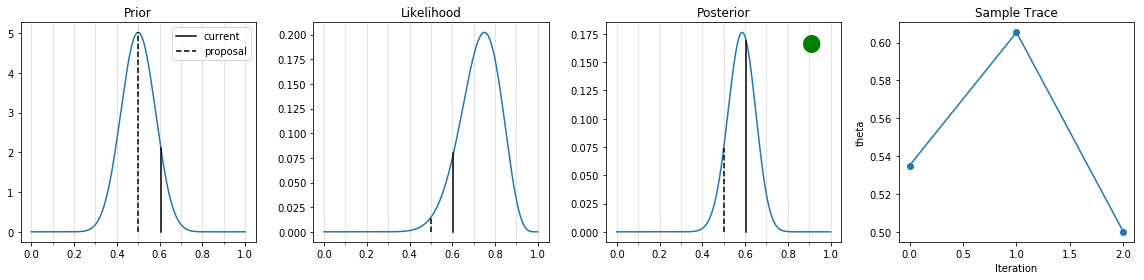

In [17]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.500235 | L = 9.582e-07 prior = 5.014806
proposal: 0.368021 | L = 3.102e-08 prior = 1.271515

threshold = 0.008208 + random = 0.002465 -> accept


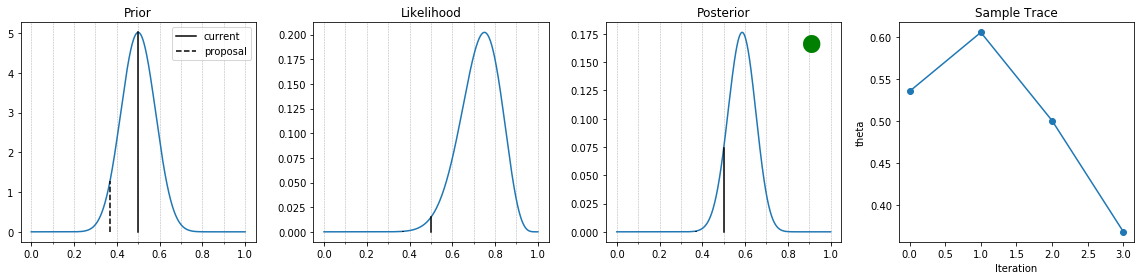

In [18]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.368021 | L = 3.102e-08 prior = 1.271515
proposal: 0.545246 | L = 2.177e-06 prior = 4.289493

threshold = 1.000000 + random = 0.884032 -> accept


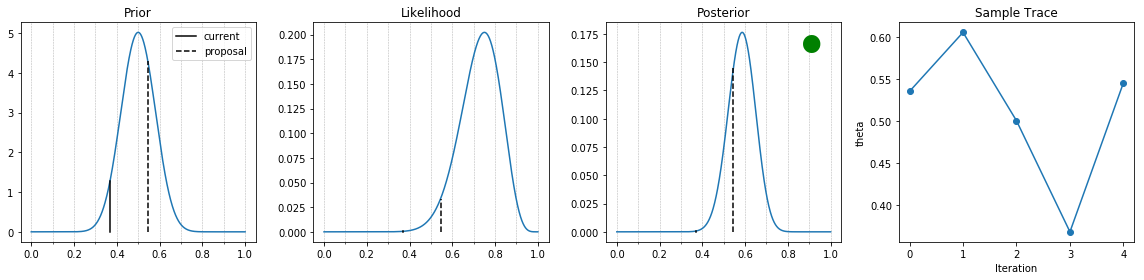

In [19]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.545246 | L = 2.177e-06 prior = 4.289493
proposal: 0.510500 | L = 1.171e-06 prior = 4.972971

threshold = 0.623937 + random = 0.589582 -> accept


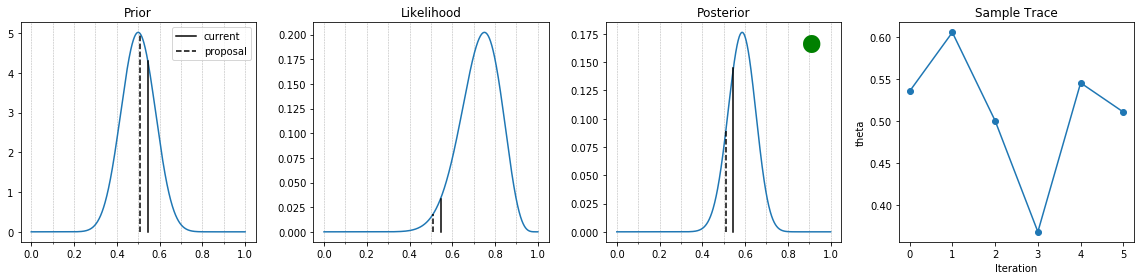

In [20]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.510500 | L = 1.171e-06 prior = 4.972971
proposal: 0.577514 | L = 3.569e-06 prior = 3.158749

threshold = 1.000000 + random = 0.978427 -> accept


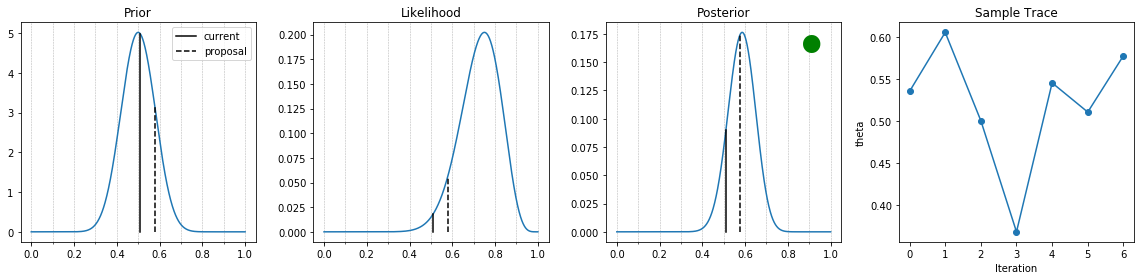

In [21]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.577514 | L = 3.569e-06 prior = 3.158749
proposal: 0.473169 | L = 5.415e-07 prior = 4.747459

threshold = 0.228060 + random = 0.822466 -> reject


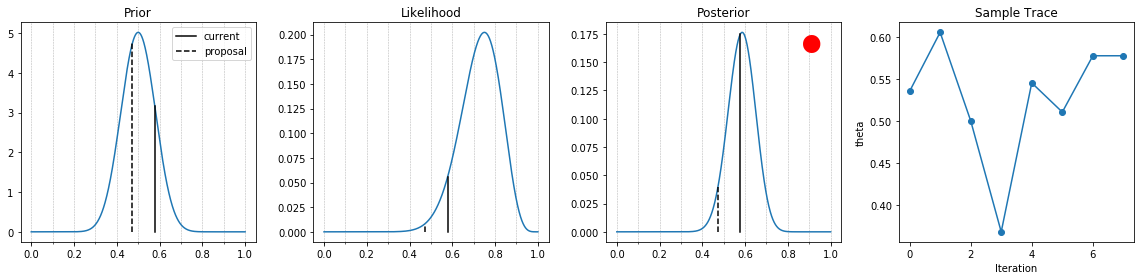

In [22]:
posterior = mcmc_step(observed, prior, posterior, True)

current:  0.577514 | L = 3.569e-06 prior = 3.158749
proposal: 0.476520 | L = 5.831e-07 prior = 4.808832

threshold = 0.248738 + random = 0.626183 -> reject


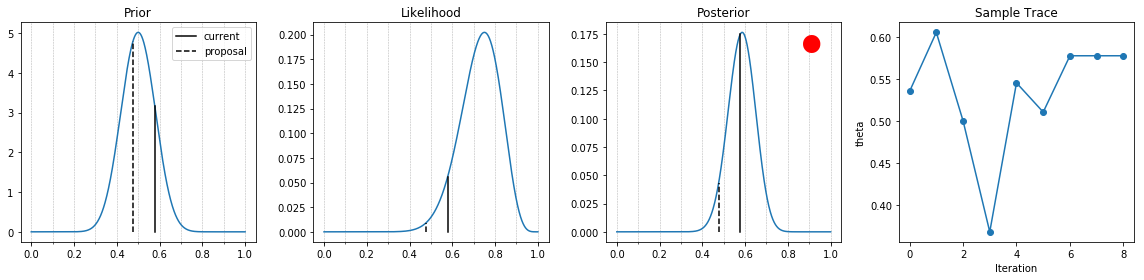

In [23]:
posterior = mcmc_step(observed, prior, posterior, True)

Generating the diagnostic plots for each sample from the posterior is inefficient, so let's just generate a bunch of samples.

Note that, although all of the existing posterior samples are passed into `sample()`, only the most recent sample is actually used to generate the new sample.

In [24]:
for i in range(5000 - len(posterior)):
    posterior = mcmc_step(observed, prior, posterior)

# Turn the result into an array.
posterior = np.array(posterior)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


### Posterior Analytics

Now that we have a bunch of samples from the posterior we can look at their distribution.

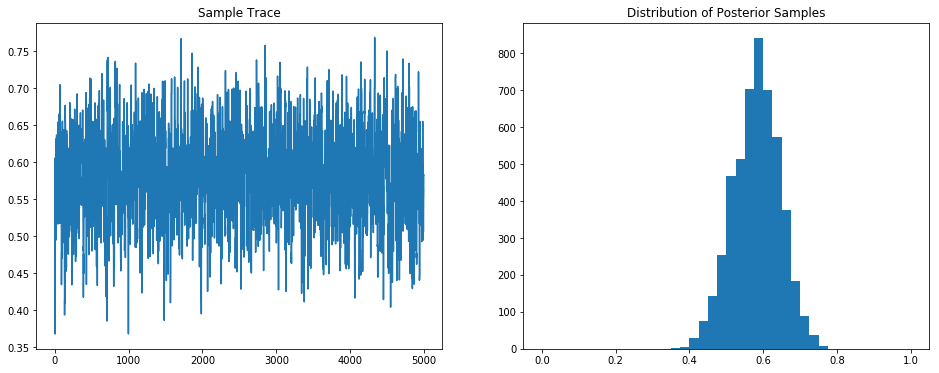

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(posterior)
ax1.set(title='Sample Trace')
ax2.hist(posterior, bins = np.linspace(0, 1, 41))
ax2.set(title='Distribution of Posterior Samples');

In [26]:
posterior.mean()

0.5819681031001992

In [27]:
posterior.std() / np.sqrt(posterior.size)

0.0008905204903809711

Simply applying the Central Limit Theorem (CLT) to find the standard deviation of the mean is not quite correct. Why? The CLT assumes that the samples are independent. However, the nature of MCMC is that the samples are quite highly correlated. To do this properly we'd need to rather use an *effective* sample size.

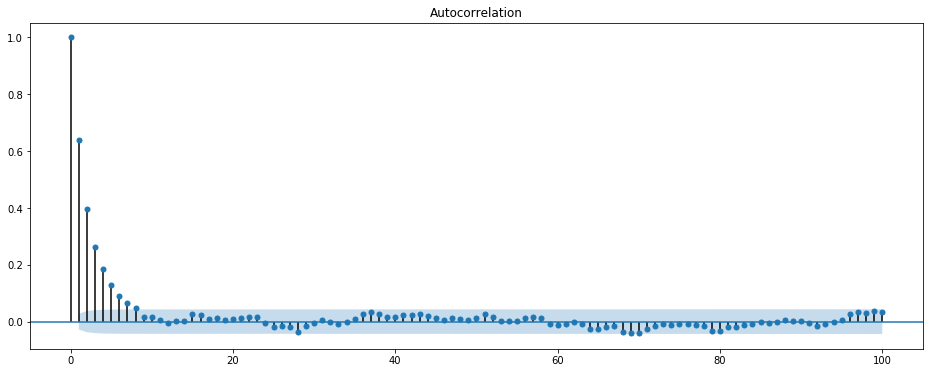

In [28]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_acf(posterior, lags=100, ax=ax);

### Generating Samples

We can now generate samples from the model which capture both

- model uncertainty and
- parameter uncertainty.

Generate a single sample.

In [29]:
# Sample value for theta from posterior.
theta = np.random.choice(posterior)
# Sample Bernoulli distribution with this success rate.
stats.bernoulli(theta).rvs()

1

Now generate a series of samples.

In [30]:
[stats.bernoulli(np.random.choice(posterior)).rvs() for i in range(10)]

[1, 0, 0, 1, 1, 0, 1, 1, 1, 0]

### Multiple Chains

How does one know whether the posterior sample has converged on the true distribution? This is still an outstanding problem, but one approach is to sample multiple chains and check that they all have similiar distributions.

In [31]:
def chain(data, prior, nsample):
    posterior = [prior.rvs()]
    for i in range(nsample-1):
        posterior = mcmc_step(data, prior, posterior)
    return np.array(posterior)

In [32]:
chains = [chain(observed, prior, 1000) for n in range(4)]

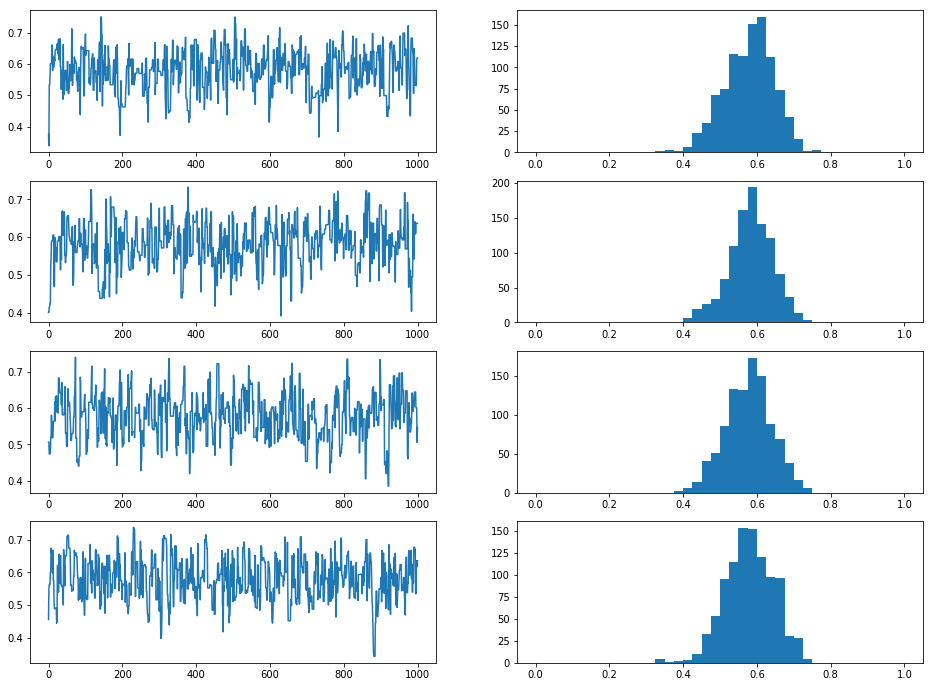

In [33]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(16, 12))
ax = ax.ravel()
for n in range(4):
    ax[2*n].plot(chains[n])
    ax[2*n+1].hist(chains[n], bins = np.linspace(0, 1, 41))

### Burn-In

You might have noticed that some of the initial samples in the above chains were far from the core of the posterior distribution. This is not uncommon and leads to the practice of "burn-in", where some portion of the initial samples in a chain are discarded on the assumption that they are potentially far from the actual distribution.

## Alternatives to Metropolis-Hastings

There are alternative implementations of MCMC which differ from the Metropolis-Hastings algorithm principally in the way that they sample the proposal.

- **Metropolis-Hastings** - perturbation to all parameters simultaneously;
- **Gibbs Sampling** - perturbation to one parameter at a time; and
- **Hamiltonian Monte Carlo** - use momentum.

More sophisticated algorithms tune the proposal selection to achieve greater efficiency.